In [2]:
%load_ext autoreload
%autoreload 2


reference:  
李宏毅  
https://www.youtube.com/watch?v=oTGFK-QOWI4
https://docs.google.com/presentation/d/1x8c38zgEbN2zN4EboWhquZ5b3LhVCN8ElhaJCO2vnzY/edit?pli=1#slide=id.g228497b0ecc_0_0  
https://www.kaggle.com/code/b07202024/hw6-diffusion-model
hugging face  
https://huggingface.co/learn/diffusion-course/unit1/3  
https://huggingface.co/docs/diffusers/tutorials/basic_training  
https://www.hyperstack.cloud/technical-resources/tutorials/how-to-train-a-stable-diffusion-model  
https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e
Youtube  
https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=1244s  
https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing  
link to MNIST dataset
https://www.kaggle.com/datasets/gosienna/minst-csv

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torchvision
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from torch import nn
import pandas as pd
import numpy as np

from ReadFolderContent import PhotoReader
from ContentToTorchLoader import CreateTorchLoader

/home/kewei/Desktop/Github/2D-Duffusion-model-from-scratch/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

In [17]:
args={}
args["batch_size"]=8
args['label_name'] = "label"
args["number_of_epoch"] = 20
args['shuffle_data'] = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
label_df = pd.read_csv("data/MINST/train_label.csv")

In [21]:
data_loader = CreateTorchLoader(PhotoReader("data/MINST/train_img", 
                                            formators=[lambda x: np.expand_dims(x, axis=0), #expand dims to (1, 256, 256)
                                                       lambda x: x/255.0]), #normalize to 0-1
                                label_df, args=args).create_torch_loader()

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 6, 5, 0, 2, 8, 4, 7])


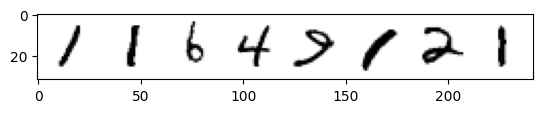

In [16]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=False, transform=torchvision.transforms.ToTensor()
)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x2, y2 = next(iter(train_dataloader))
print("Input shape:", x2.shape)
print("Labels:", y2)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

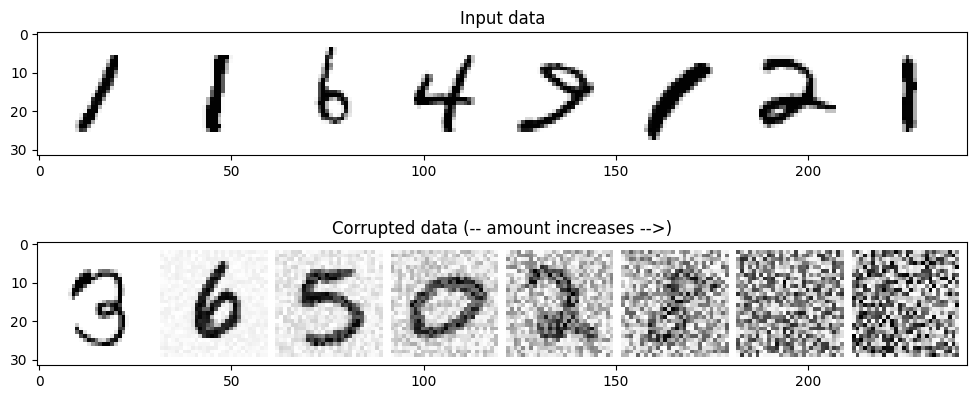

In [18]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x2.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x2, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

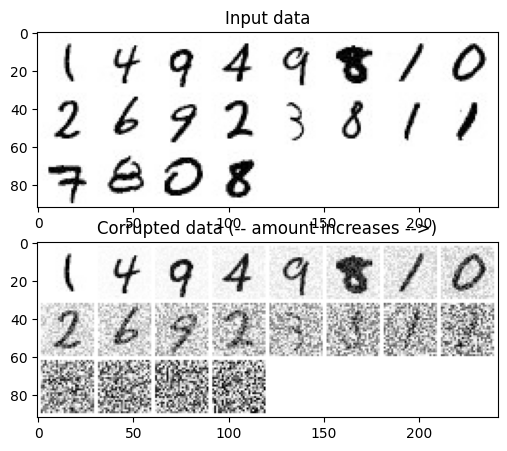

In [48]:
x, y = next(iter(data_loader))
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption

# def corrupt(x, amount):
"""Corrupt the input `x` by mixing it with noise according to `amount`"""
noise = torch.rand_like(x)
amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
noised_x= x * (1 - amount) + noise * amount

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [32]:
pred.shape

torch.Size([64, 1, 28, 28])

In [ ]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = CreateTorchLoader(PhotoReader("data/MINST/train_img", 
                                            formators=[lambda x: np.expand_dims(x, axis=0), #expand dims to (1, 256, 256)
                                                       lambda x: x/255.0]), #normalize to 0-1
                                label_df, args=args).create_torch_loader()

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')


In [34]:
pred.shape

torch.Size([8, 1, 28, 28])

In [ ]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');